<a href="https://www.kaggle.com/code/mikedelong/lots-of-words-tends-to-yield-lots-of-thumbs?scriptVersionId=140220624" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/37000-reviews-of-thread-app-dataset/37000_reviews_of_thread_app.csv', index_col=[0],
                parse_dates=['review_date'])
# language code is always en so we can drop it
# country code is always us so we can drop it
# developer response and developer response date are always null so we can drop them
# and review ID is a GUID and contains no information so we can drop it
drop_columns = ['review_id', 'developer_response', 'developer_response_date', 'laguage_code', 'country_code']
df = df.drop(columns=drop_columns)
# we want to segment our time series to day granularity
df['review_day'] = df['review_date'].apply(func=lambda x: (x- df['review_date'].min()).days)
df.head()

,source,user_name,review_title,review_description,rating,thumbs_up,review_date,appVersion,review_day
0,Google Play,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07 19:14:36,294.0.0.27.110,32
1,Google Play,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,NaN,32
2,Google Play,SITI NUR HAFIZA BINTI AZIZ,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,294.0.0.27.110,32
3,Google Play,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07 18:37:16,NaN,32
4,Google Play,Syed Hussein,NaN,Very god,5,0.0,2023-08-07 18:14:15,NaN,32


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36943 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   source              36943 non-null  object        
 1   user_name           36943 non-null  object        
 2   review_title        2000 non-null   object        
 3   review_description  36943 non-null  object        
 4   rating              36943 non-null  int64         
 5   thumbs_up           34943 non-null  float64       
 6   review_date         36943 non-null  datetime64[ns]
 7   appVersion          24855 non-null  object        
 8   review_day          36943 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 2.8+ MB


In [3]:
df.nunique()

source                    2
user_name             35942
review_title           1838
review_description    30086
rating                    5
thumbs_up               149
review_date           35665
appVersion                7
review_day               33
dtype: int64

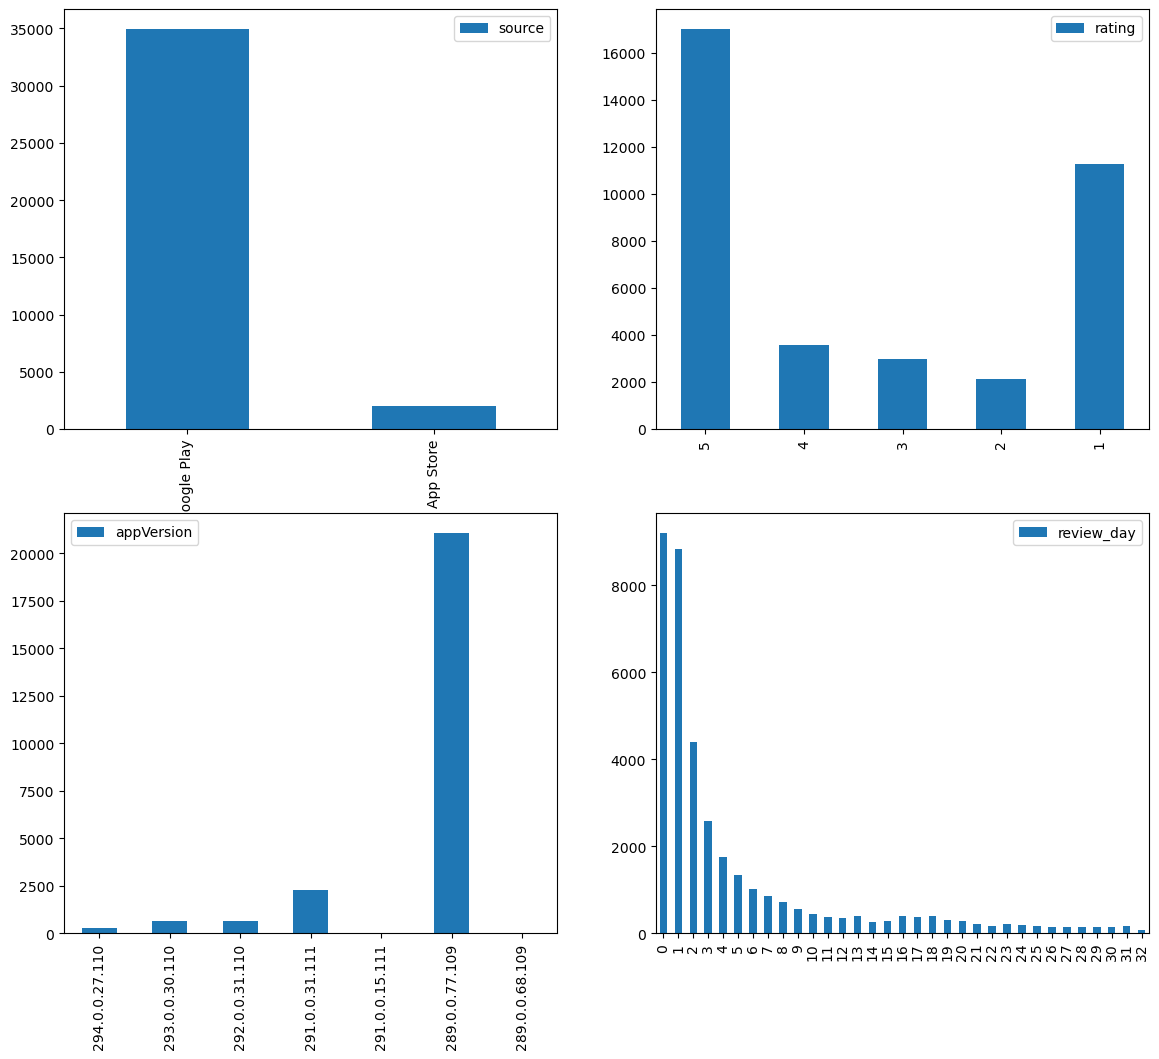

In [4]:
from matplotlib.pyplot import subplots
fig, ax = subplots(figsize=(14, 12), ncols=2, nrows=2)
for index, column in enumerate(['source', 'rating', 'appVersion', 'review_day']):
    # we want to sort one way for rating and another way for our time proxy
    ascending = column == 'review_day'
    df[column].value_counts().to_frame().sort_index(ascending=ascending).plot(ax=ax.ravel()[index], kind='bar', legend=True)

The fact that rating is bimodal isn't surprising; but the way review counts die off is kind of surprising, I guess.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='review_day', ylabel='rating'>

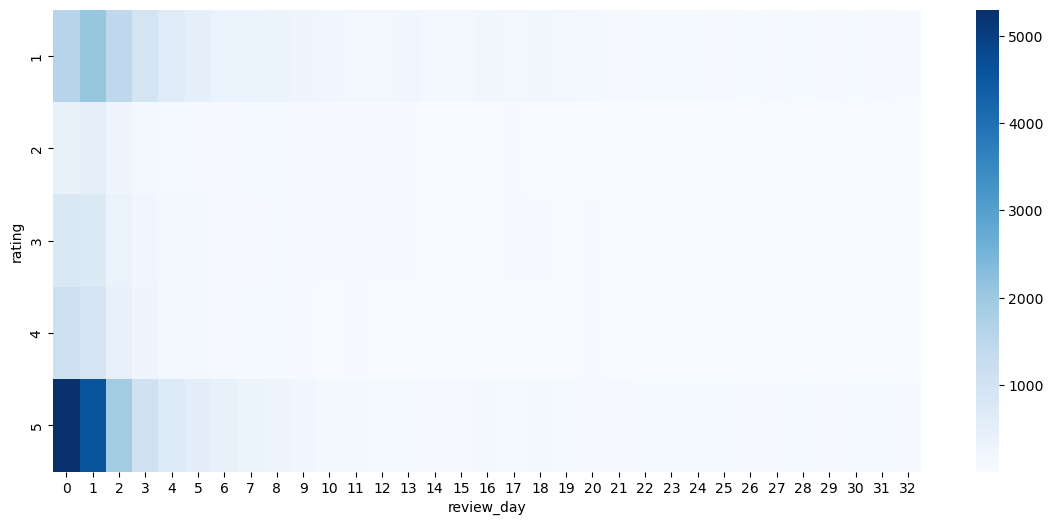

In [5]:
from seaborn import heatmap
fig, ax = subplots(figsize=(14, 6),)
day_rating = ['review_day', 'rating']
heatmap(cmap='Blues', data=pd.pivot_table(data=df[day_rating].groupby(day_rating).size().reset_index(),
                                          index=day_rating[1], columns=day_rating[0], values=0), square=False, )

It is kind of surprising how much the total ratings are dominated by the ratings from the first couple of days. What is the mean rating?

In [6]:
df['rating'].mean()

3.3493760658311453

<Axes: xlabel='review_day', ylabel='rating'>

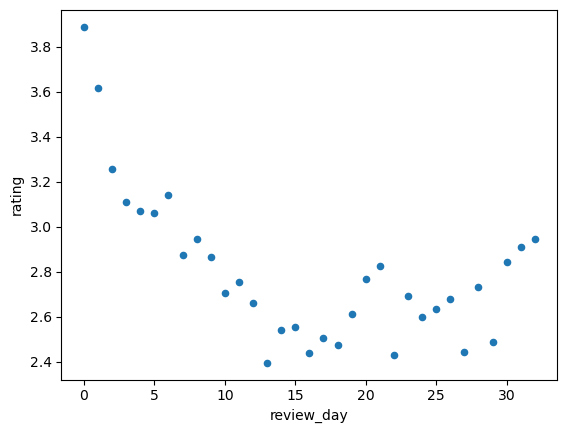

In [7]:
# let's look at the average rating time series
df[day_rating].groupby(day_rating[0])[day_rating[1]].mean().to_frame().reset_index().plot(kind='scatter', legend=True, x='review_day', y='rating')

The mean rating is dominated by the ratings from the first couple of days, of course, but that hides the fact that later raters rated about a full point lower than the mean.

In [8]:
df['thumbs_up'].value_counts()

0.0      30611
1.0       2889
2.0        520
3.0        193
4.0        124
         ...  
164.0        1
91.0         1
547.0        1
268.0        1
114.0        1
Name: thumbs_up, Length: 149, dtype: int64

Ah. The thumbs-up are ratings of the ratings, not ratings of the app. They might be helpful for weighting the reviews.

In [9]:
df['weighted_rating'] = df['rating'] * df['thumbs_up']
df['weighted_rating'].mean()

5.110236671150159

In [10]:
df['thumbs_up'].mean()

1.8168445754514495

In [11]:
df['rating'].mean() * df['thumbs_up'].mean()

6.085295736352234

If every rating got the mean number of thumbs up then the thumb-weighted mean rating would be about 6.1, but instead it is 5.1. This suggests that more negative than average reviews get more thumbs up than positive reviews. Of course this might be typical for a social media application, so there's not a lot we can interpret here.

Before we go let's look at the source/version heatmap, which we expect to be mostly uninformative.

<Axes: xlabel='source', ylabel='appVersion'>

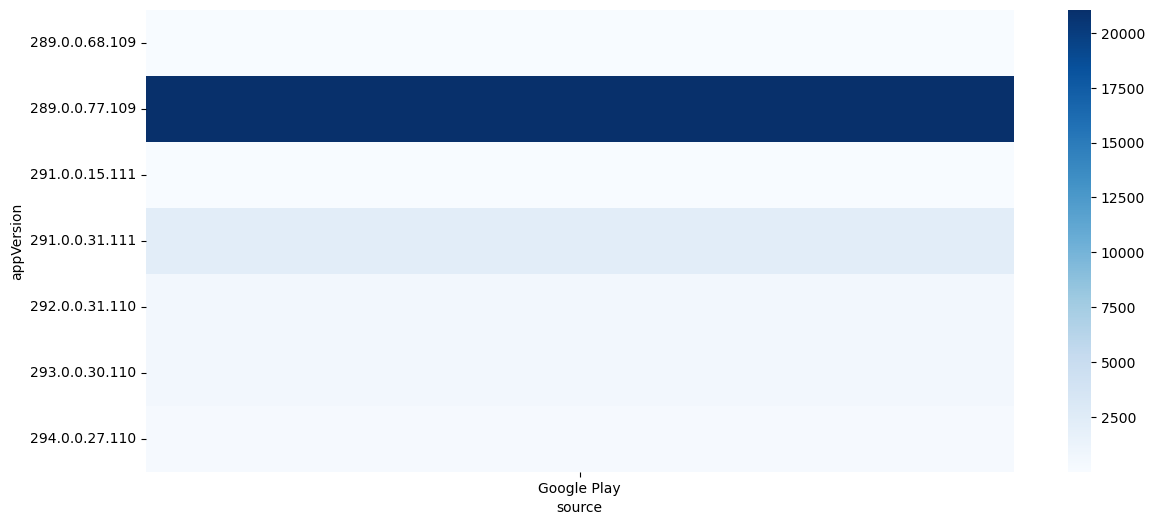

In [12]:
fig, ax = subplots(figsize=(14, 6),)
source_version = ['source', 'appVersion']
heatmap(cmap='Blues', data=pd.pivot_table(data=df[source_version].groupby(source_version).size().reset_index(),
                                          index=source_version[1], columns=source_version[0], values=0), )

Turns out we don't have version information for the Apple downloads. Go figure.

Let's look at thumbs up as a function of description length; we expect to find low-engagement and high-engagement regimes, meaning that it's reasonable to expect reviews with more than a certain number of words to get lots of thumbs/engagement, and below that threshold it's hit and miss.

In [13]:
# for our X variable we count tokens using split
df['description_length'] = df['review_description'].apply(lambda x: 0 if not isinstance(x, str) else len(x.split()))
scatter_columns = ['description_length', 'thumbs_up']
df[scatter_columns].head()

,description_length,thumbs_up
0,1,0.0
1,4,0.0
2,24,0.0
3,2,0.0
4,2,0.0


<Axes: xlabel='description_length', ylabel='thumbs_up'>

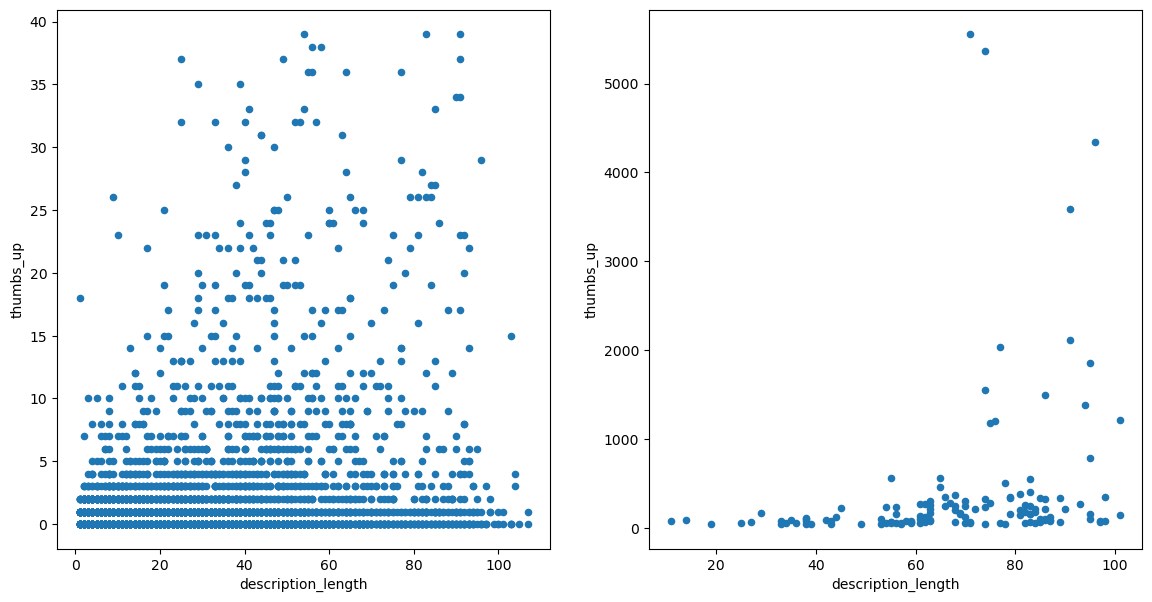

In [14]:
# we can pick our cutoff arbitrarily or we can fit it from our next graph
cutoff = 40
fig, ax = subplots(figsize=(14, 7), ncols=2, nrows=1)
df[df[scatter_columns[1]] < cutoff][scatter_columns].plot(ax=ax[0], kind='scatter', x=scatter_columns[0], y=scatter_columns[1])
df[df[scatter_columns[1]] > cutoff][scatter_columns].plot(ax=ax[1], kind='scatter', x=scatter_columns[0], y=scatter_columns[1])

So yeah we can see low-engagement and high-engagement regimes; can we measure them with the mean?

<Axes: xlabel='description_length', ylabel='thumbs_up'>

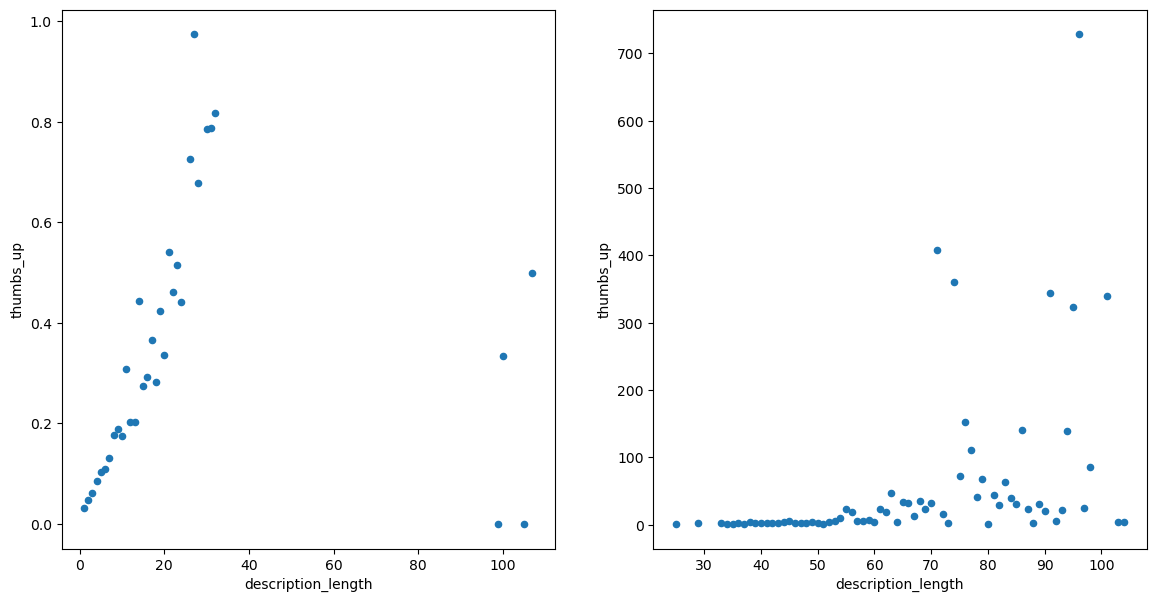

In [15]:
pivot_df = pd.pivot_table(data=df[scatter_columns], index=scatter_columns[0], values=scatter_columns[1]).reset_index()
fig, ax = subplots(figsize=(14, 7), ncols=2, nrows=1)
pivot_df[pivot_df[scatter_columns[1]] < 1].plot(ax=ax[0], kind='scatter', x=scatter_columns[0], y=scatter_columns[1])
pivot_df[pivot_df[scatter_columns[1]] > 1].plot(ax=ax[1], kind='scatter', x=scatter_columns[0], y=scatter_columns[1])

Wild how that low-engagement regime shows up clearly in the pivot table. And also how much some of those book-length reviews dominate the analysis.